# imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from kan import KAN
from kan.utils import create_dataset
from kan.utils import ex_round

# func

In [16]:
def predict_plot():
    # === 4. Предсказания ===
    with torch.no_grad():
        y_pred_train = model(dataset['train_input'])
        y_pred_test = model(dataset['test_input'])

        # Создаём монотонную сетку для плавного графика предсказаний
        x_grid = np.arange(-2, 2.1, 0.1)  # от -2 до 2 с шагом 0.1
        x_grid_tensor = torch.tensor(x_grid, dtype=torch.float32, device=device).unsqueeze(1)
        y_pred_grid = model(x_grid_tensor).cpu().numpy().flatten()

    # Переводим в numpy
    x_train = dataset['train_input'].cpu().numpy().flatten()
    y_train_true = dataset['train_label'].cpu().numpy().flatten()

    x_test = dataset['test_input'].cpu().numpy().flatten()
    y_test_true = dataset['test_label'].cpu().numpy().flatten()
    y_test_pred = y_pred_test.cpu().numpy().flatten()

    # === 5. Визуализация ===
    plt.figure(figsize=(18, 5))

    # --- Истинные значения (тест и обучение) ---
    plt.subplot(1, 3, 1)
    plt.scatter(x_test, y_test_true, s=15, alpha=0.6, label='Истинные (тест)')
    plt.scatter(x_train, y_train_true, s=15, alpha=0.6, label='Истинные (обучающая)')
    # Идеальная кривая
    x_clean = np.linspace(-2, 2, 300)
    y_clean = f_clean(x_clean).flatten() 
    plt.plot(x_clean, y_clean, 'r', linewidth=2, label='Идеальная f(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Истинные значения')
    plt.legend()
    plt.grid(True)

    # --- Предсказания модели на монотонной сетке ---
    plt.subplot(1, 3, 2)
    plt.plot(x_grid, y_pred_grid, color='green', linewidth=2, label='Предсказания (сетка)')
    plt.scatter(x_test, y_test_true, s=15, alpha=0.6, label='Истинные (тест)')
    plt.scatter(x_train, y_train_true, s=15, alpha=0.6, label='Истинные (обучающая)')
    plt.xlabel('x')
    plt.ylabel('ŷ')
    plt.title('Предсказания KAN (на сетке x ∈ [-2, 2], Δx=0.1)')
    plt.legend()
    plt.grid(True)

    # --- Ошибка (тест) ---
    error = np.abs(y_test_true - y_test_pred)
    plt.subplot(1, 3, 3)
    plt.scatter(x_test, error, s=15, alpha=0.6, color='purple')
    plt.xlabel('x')
    plt.ylabel('|y - ŷ|')
    plt.title('Абсолютная ошибка (тест)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Просмотр

In [17]:
def f_clean(x):
    # x — массив numpy или тензор PyTorch, shape (N,) или (N, 1)
    if isinstance(x, torch.Tensor):
        return torch.sin(torch.pi * x[:, [0]]**2) + x[:, [0]]**2
    else:
        # x — numpy array, shape (N,) или (N, 1)
        x = np.atleast_1d(x).reshape(-1, 1)
        return np.sin(np.pi * x[:, 0]**2) + x[:, 0]**2
def f_noisy(x, noise_level=0.1):
    y_clean = f_clean(x)  # используем общую чистую функцию
    noise = torch.randn_like(y_clean) * noise_level
    return y_clean + noise

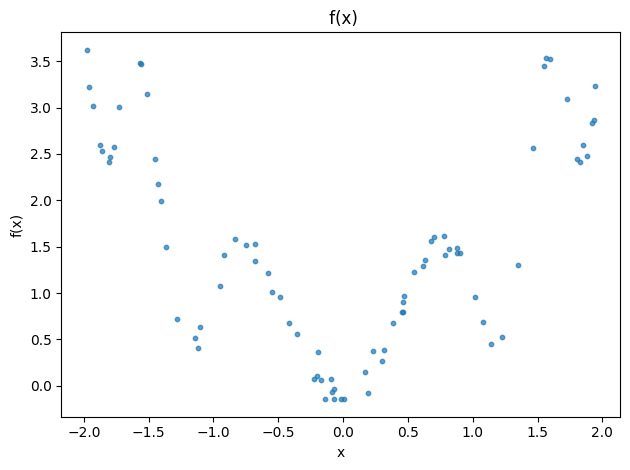

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# === 2. Создаём датасет через create_dataset ===
dataset = create_dataset(
    f=lambda x: f_noisy(x, noise_level=0.1),
    n_var=1,
    ranges=[-2, 2],       # x и y ∈ [-2, 2]
    train_num=80,
    test_num=20,
    device=device,
    seed = 10
)

# Извлекаем данные
x_train = dataset['train_input'].cpu().numpy()  # shape: (1000, 2)
y_train = dataset['train_label'].cpu().numpy().flatten()  # shape: (1000,)

# === 3. Визуализация ===

# --- 3D scatter plot ---
fig, ax = plt.subplots()


# --- 2D scatter (x vs f) с цветом по y ---

scatter = ax.scatter(x_train[:, 0], y_train, s=10, alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(' f(x)')


plt.tight_layout()
plt.show()

В статье [хабр](https://habr.com/ru/articles/856776/) предлагается вот такой метод работы с KAN.

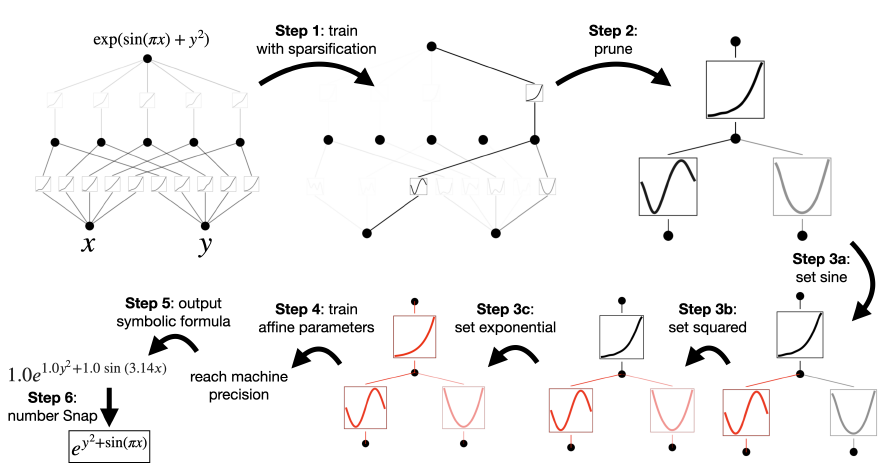

Если использовать автоподбор функций, то они выбираются таким образом:
1. Выбирается сплайн
2. Происходит выбор функции (описано позже)
3. Запоминается выбранная функция
4. Выбирается следующий сплайн...

Таким образом функция для замены конкретного сплайна подбирается независимо от остальных. Для каждой новой итерации и функции KAN - набор сплайнов. И только когда все функции выбраны происходит полная замена сплайнов на функции.

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 9.40e-02 | test_loss: 1.23e-01 | reg: 1.42e+01 | : 100%|█| 50/50 [00:10<00:00,  4.85it


saving model version 0.1
Модель после обучения:


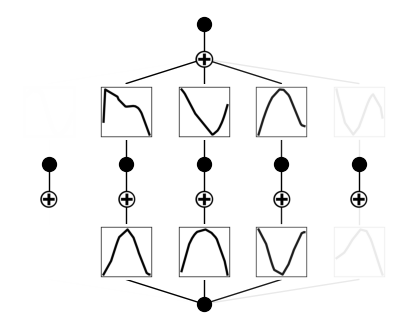

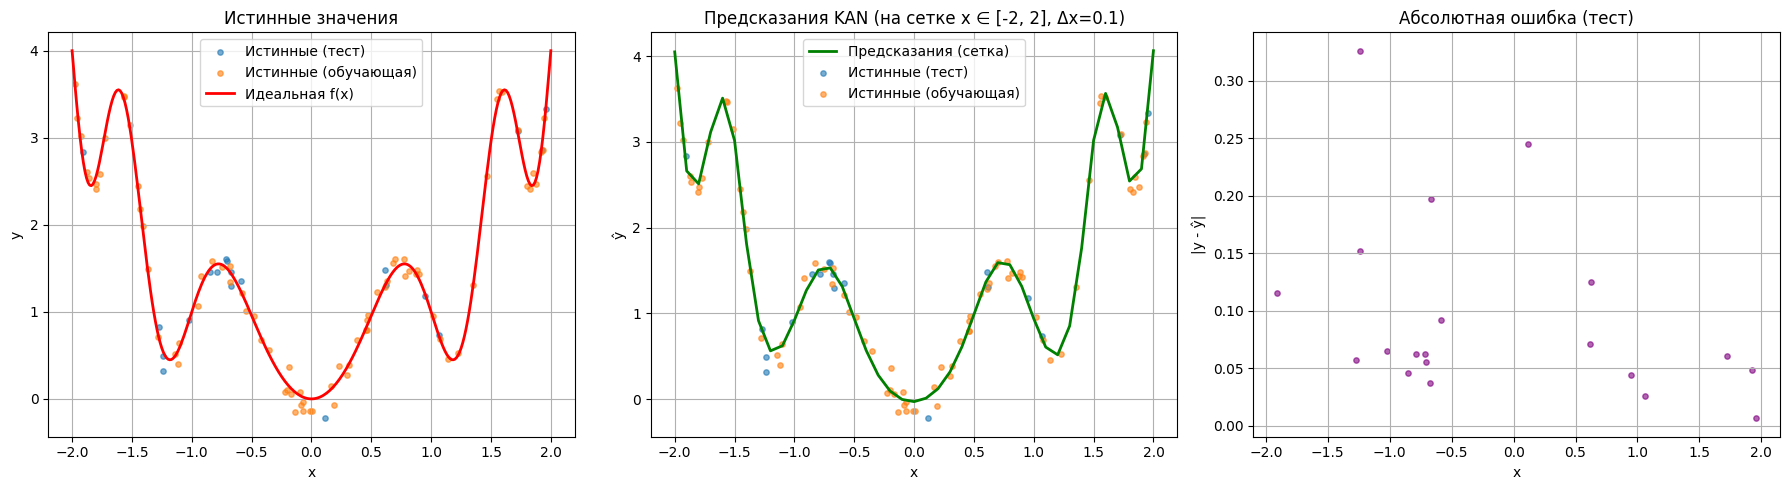

saving model version 0.2
Модель после прореживания:


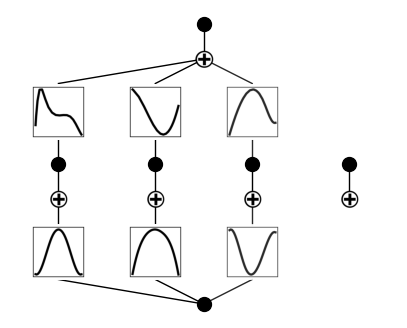

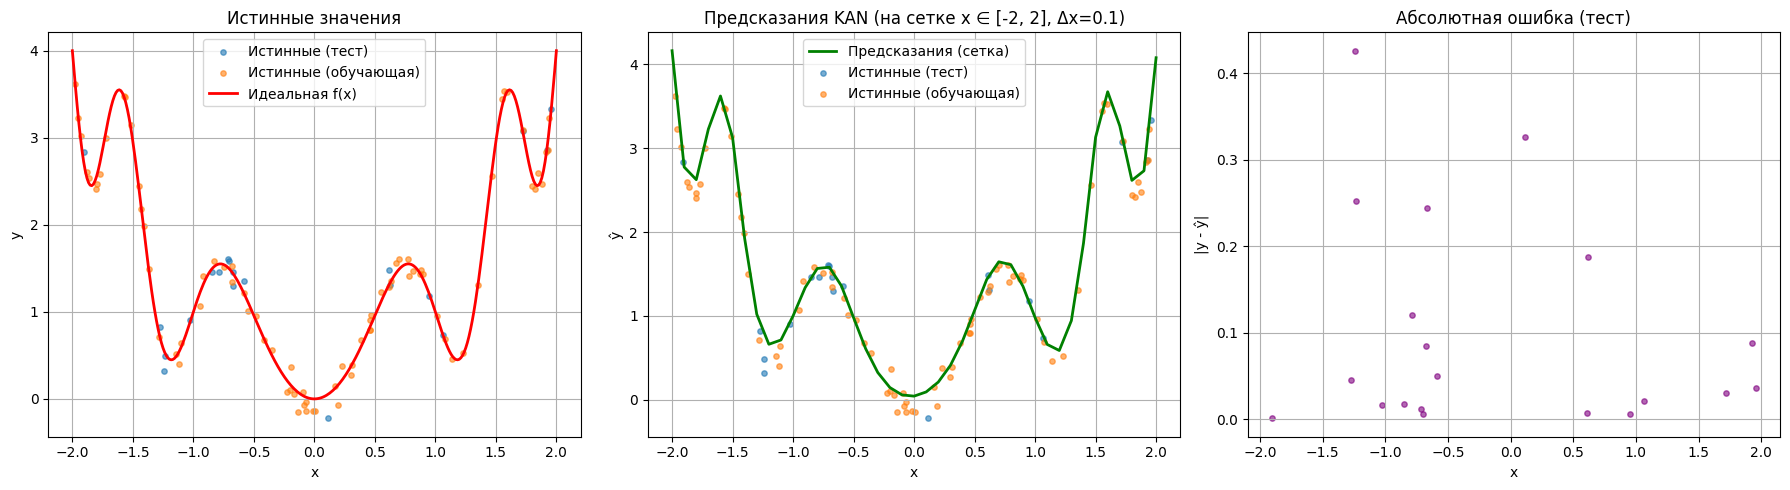

| train_loss: 9.24e-02 | test_loss: 1.26e-01 | reg: 7.52e+00 | : 100%|█| 50/50 [00:09<00:00,  5.01it


saving model version 0.3
Модель после второго обучения:


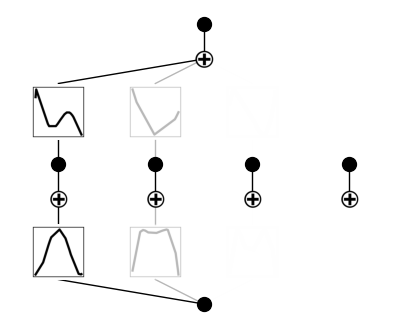

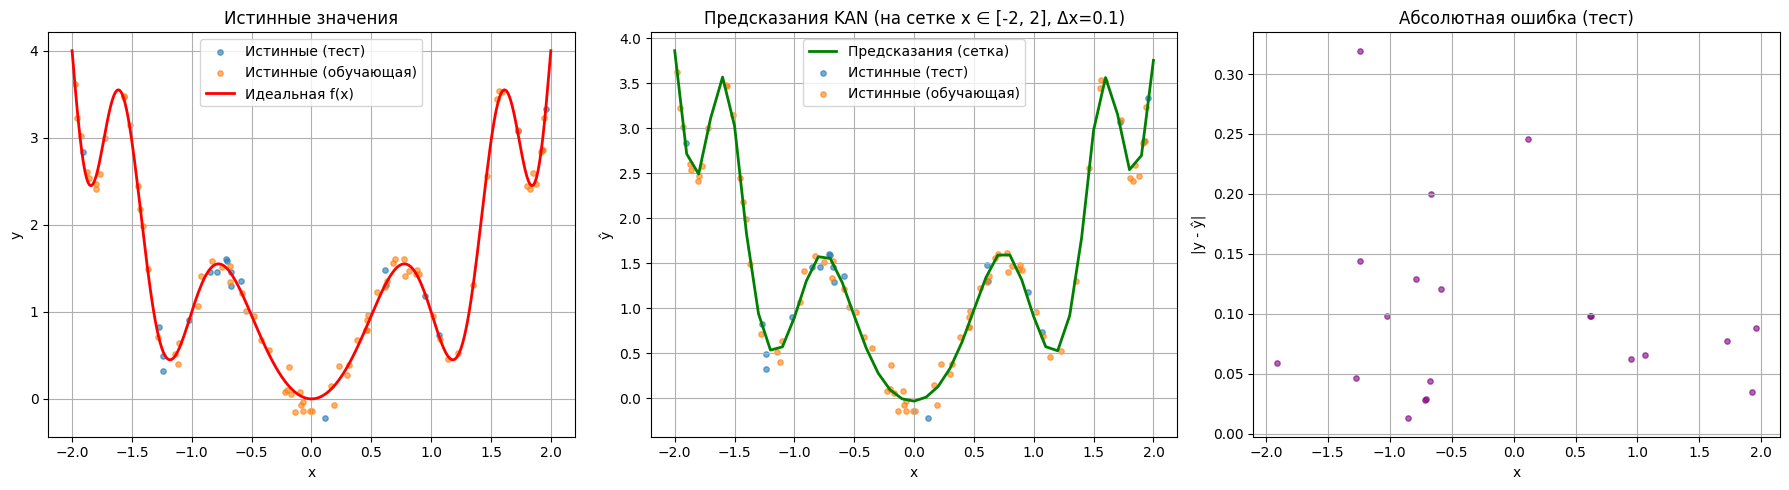

In [23]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[1, 5, 1], grid=3, k=3, seed=42, device=device)
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
print(f'Модель после обучения:')
model.plot()
predict_plot()
model = model.prune()
print(f'Модель после прореживания:')
model.plot()
predict_plot()
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, update_grid=False)
print(f'Модель после второго обучения:')
model.plot()
predict_plot()

Прореживание это удаление узлов из KAN с околонулевыми весами.
Используя прореживание можно найти тот минимальный набор узлов, который необходим. Однако это не гаратирует, что он будет верным.
У прореживания есть настраеваемый порог для ребёр и для узлов. По умолчанию он задан
```
def prune(self, node_th=1e-2, edge_th=3e-2)
    Args:
    -----
        node_th : float
            if the attribution score of a node is below node_th, it is considered dead and will be set to zero.
        edge_th : float
            if the attribution score of an edge is below node_th, it is considered dead and will be set to zero.
```
Не знаю есть ли смысл этот порог трогать. Наверное, только если ускорить зануление весов. Так считаю, потому что если убрать незанулённые рёбра, то остальные нужно будет подстроить. Если не подстроить, т.е. не провести ещё раз обучение, то итоговая функция будет смещена.

fixing (0,0,0) with sin, r2=0.9988625049591064, c=2
fixing (0,0,1) with x, r2=0.00016523113299626857, c=1
fixing (0,0,2) with x, r2=0.006702738348394632, c=1
fixing (0,0,3) with 0
fixing (1,0,0) with x, r2=0.6620303988456726, c=1
fixing (1,1,0) with x^2, r2=0.9990166425704956, c=2
fixing (1,2,0) with x, r2=0.22226864099502563, c=1
fixing (1,3,0) with 0
saving model version 0.4


| train_loss: 5.53e-01 | test_loss: 7.08e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:02<00:00,  6.70it


saving model version 0.5
0.0104997282742985*x_1 + 0.0126616777852178*(2.20618118579687 - 2.08437732195145*x_1)**2 - 1.3797472446297*sin(1.31194269657135*x_1 + 1.74189686775208) + 1.61838186542343


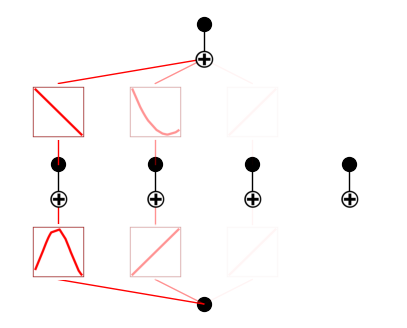

In [24]:
# 3. Символьная подгонка
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
#lib = ['sin', 'x^2']
model.auto_symbolic(lib=lib)

# 4. Финальное обучение с фиксированными функциями
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.0001, update_grid=False)
print(model.symbolic_formula()[0][0])
model.plot()

Можно увидеть, что на самом деле функции подобранные автоматически не сильно-то и похожи на те сплайны, что получились. Как итог ниже можно увидеть, что выход KAN выродился в параболу.

**Как подбираются эти функции?**

Выбирается функция с максимумом по *$r^2$* и минимумом по *c*. *c* - complexity score

> Each symbolic function is assigned a complexity score c (e.g., c=1 for x, c=2 for sin(x), c=3 for special functions). The total complexity of a KAN is the sum of c over all edges.

In [25]:
ex_round(model.symbolic_formula()[0][0],4)

0.0105*x_1 + 0.0127*(2.2062 - 2.0844*x_1)**2 - 1.3797*sin(1.3119*x_1 + 1.7419) + 1.6184

Если продолжить обучение дальше, то будут подстраиваться уже функции, а не сплайны. Значит гибкости уже не будет.

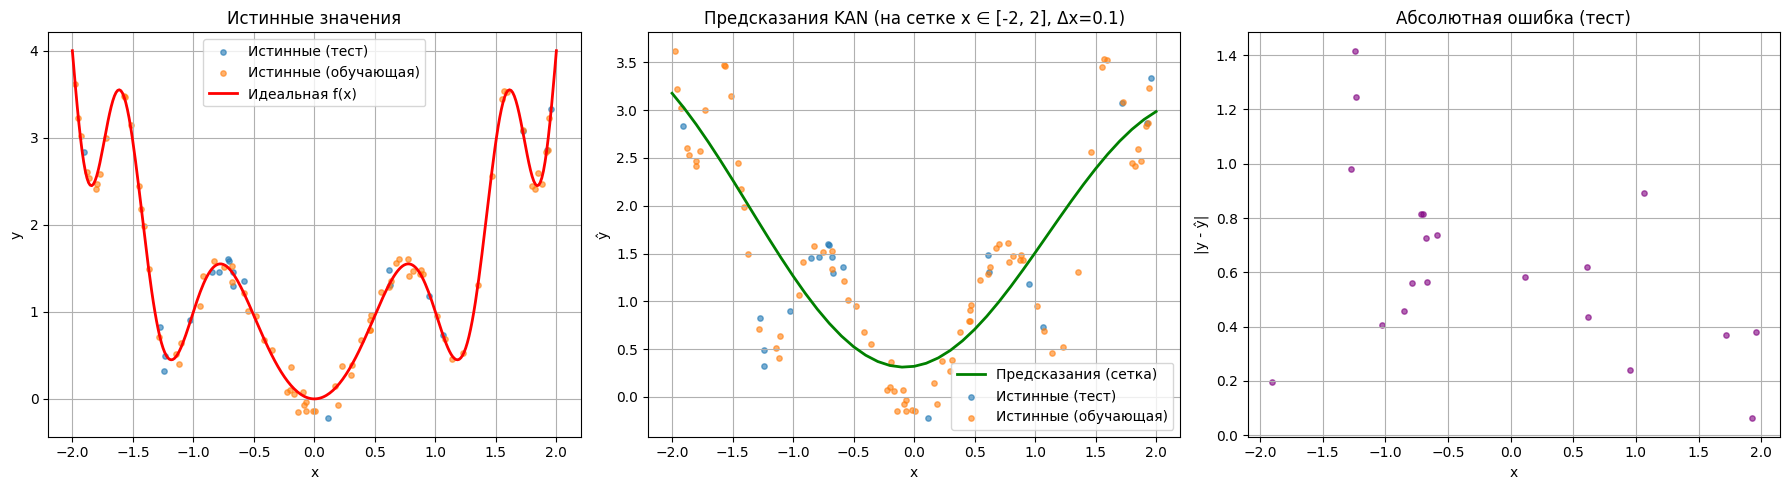

In [26]:
predict_plot()

В статье приведено несколько способов как производить замену сплайнов на функции.

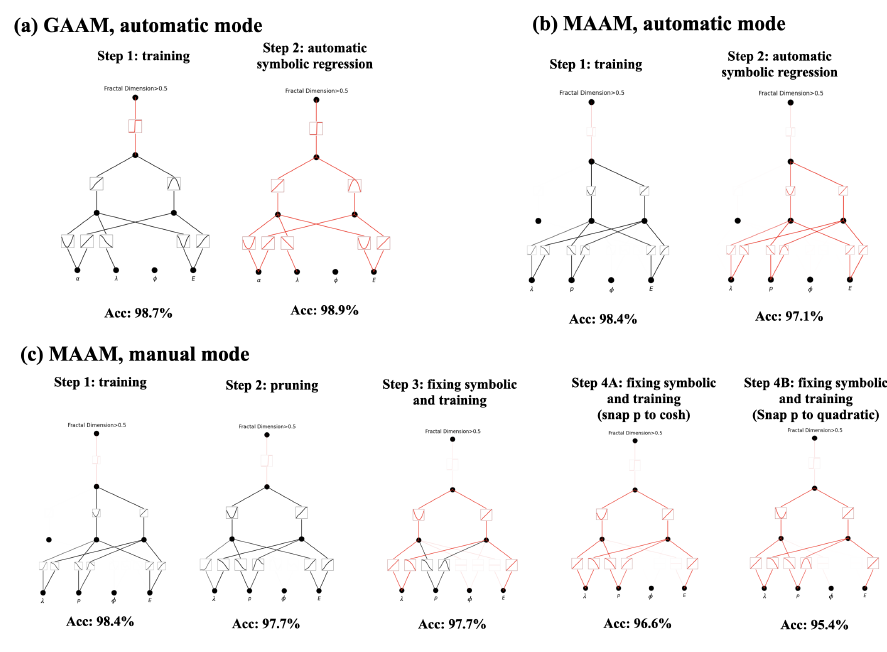

Возможно, стоит рассмотреть автоматизацию ручного подбора.
Возможно, стоит рассмотреть подбор функций с помощью ГА. В предложенном алгоритме не учитывается влияние выбора функции на одном узле на выбор функции на другом. Однако авторами статьи (или библиотеки) утверждается, что этот подход приводит к хорошим локальным минимумам ошибки, а перебор всех функций крайне трудозатратен.

Так же для оптимизации могут быть выбраны гипер параметры модели

```python
initalize a KAN model

Args:
-----
grid : int
    number of grid intervals. Default: 3.
k : int
    order of piecewise polynomial. Default: 3.
base_fun : str
    the residual function b(x). Default: 'silu'
affine_trainable : bool
    affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
grid_eps : float
    When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
grid_range : list/np.array of shape (2,))
    setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
sp_trainable : bool # коэффициент сплайна
    If true, scale_sp is trainable. Default: True.
sb_trainable : bool # коэффициент базовой функции
    If true, scale_base is trainable. Default: True.
```


Сами авторы статью утверждают, что адаптация сетки с помощью сильных алгоритмов - наиболее вероятное развитие KAN.